In [1]:
latex.add_to_preamble("\\usepackage{amsmath}")

In [2]:
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath}')

# Monitoring temporal properties of continuous systems under masks
Thomas Wright

## A continuous dynamical model

An ODE model:

\begin{align}
    \frac{\mathrm d x}{\mathrm d t}
    & = bx(1 - x) - cx(k - x)y \\
    \frac{\mathrm d y}{\mathrm d t}
    & = - ey(1 + y) + fx(k - x)y
\end{align}

can be specified directly via ODEs or using a higher-level modelling language such as the bond-calculus

$x$ prey, $y$ predator, $b$ growth rate of $x$, $c$ damage intensity of $x$ on $y$,
$e$ predator death rate, $e$ benefit from predation.

Interesting feature: predator and prey switch role depending on concentrations.



In [3]:
from ulbc import *

In [4]:
R.<x,y> = QQ[]
us = [x,y]
k=RIF(0.8); b=RIF(0.6); c=RIF(0.3); e=RIF(0.05); f=RIF(2)
vf = vector([b*x*(RIF(1)-x) - c*x*(k-x)*y,
            -e*y*(RIF(1)+y)+f*x*(k-x)*y])
v0 = [RIF(0.5), RIF(2.0)]
v1 = [RIF(0.4), RIF(2.5)]
v2 = [RIF(1,1.2), RIF(4,6)]

In [5]:
p = streamline_plot(tuple(vf),(x,0,1.5),(y,0,8), density=1.2)#, axes_labels=["$x$", "$y$"])
s = lambda: p.show(figsize=[16,8], axes_pad=False)

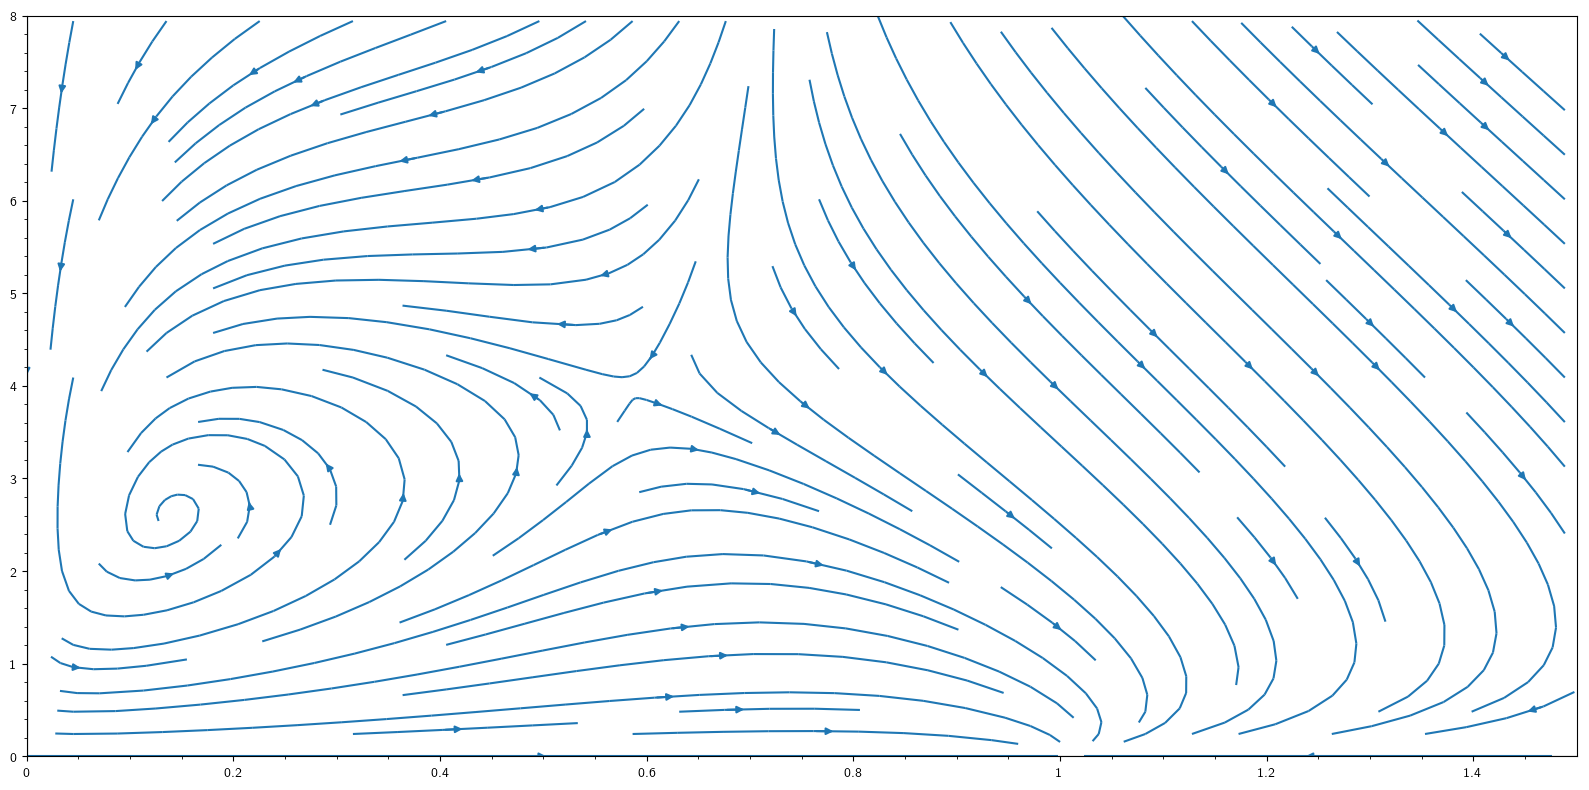

In [6]:
s()

In [7]:
Reach(vf, v2, 1, step=0.02, order=5,
      precondition=1,
      estimation=1e-3,
      integrationScheme=2,
      cutoff_threshold=1e-7,
      symbolic_composition=True,
      precompose_taylor_models=True, verbosity=10).num_flowpipes

run = True
vars = ['x', 'y']
var = x type(var) = <class 'str'> var_str = x
var = y type(var) = <class 'str'> var_str = y
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing

50

## Temporal properties

Many interesting properties of this system can be specified in temporal logic
$$
\begin{array}{rccccc}
    \varphi, \psi &\mathrel{::=}&
        g(\mathrm x) > 0 \\
        &|&
        \varphi \wedge \psi
        &|&
        \varphi \vee \psi
        &|&
        \neg \varphi\\
        &|&
        \mathop{\mathbf{G}_{[a, b]}} \varphi
        &|&
        \mathop{\mathbf{F}_{[a, b]}} \varphi
        &|&
        \varphi \mathop{\mathbf{U}_{[a, b]}} \psi
\end{array}
$$
where $g(\mathbf x)$ is a function (e.g. polynomial) of the state variables.

e.g.
 - $$\mathop{\mathbf{G}_{[0, 5]}} ((x - 1)^2 + y^2 > 0.2)$$
 - $$\mathop{\mathbf{F}_{[0, 5]}} ((x - 1)^2 + y^2 > 0.2)$$
 - $$((x - 1)^2 + y^2 > 0.2) \mathop{\mathbf{U}_{[0, 5]}} (x > 1.3)$$

Also interesting: Context operators $\mathcal C \triangleright \varphi$

e.g.
$$\mathop{\mathbf{G}_{[0, 5]}} (\mathop{\mathbf{F}_{[0, 5]}} ((x - 1)^2 + y^2 > 0.2))$$

### Verification using flow*

Flow* performs validated integration of continuous system: given a system $\frac{\mathrm{d} \mathbf x}{\mathrm d t} = f(\mathrm x)$ and set of initial conditions $\mathbf x_{0} \in B$, returns a sequence of *Taylor models*
$$
    (\mathbf p_1, I_1), \ldots, (\mathbf p_n, I_n)
$$
consisting of (vectors of) polynomials $p_k:B \times [a_k, b_k] \rightarrow {\mathbb R}^n$ and (vectors of) intervals $I_k$ which jointly enclose the solution.

In [8]:
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout
            
            
import warnings
            
@contextmanager
def suppress_warnings():
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        yield

In [9]:
#input_box("1,1.2", label="$x$")
import time

reach = None

def pfun(xvar=range_slider(0, 1.4, default=(1, 1.2), label="$x$"),
         yvar=range_slider(0, 8, default=(4, 6), label="$y$"),
         #step=slider(0, 0.2, default=0.02, label="step", step_size=0.001),
         #order=slider(0, 20, default=5, label="order", step_size=1),
         auto_update=False):
    global reach
    
    step = 0.02
    order = 5
    
    p = streamline_plot(tuple(vf), (x,0,1.5), (y,0,8), density=1.2, color='gray')#, axes_labels=["$x$", "$y$"])
    v = vector([RIF(xvar), RIF(yvar)])
    initials = [xvar, yvar]
    p += polygon([(v[0].lower(), v[1].lower()),
                  (v[0].lower(), v[1].upper()),
                  (v[0].upper(), v[1].upper()),
                  (v[0].upper(), v[1].lower())],
                  color='orange')
    with suppress_stdout():
        t0 = time.time()
        reach = Reach(vf, initials, 2*pi, step=step, order=order, precompose_taylor_models=True)
        t1 = time.time()
        if reach.ran:
            p += reach.sage_interval_plot('x', 'y', aspect_ratio='automatic')
    p.set_aspect_ratio(1/8)
    p.show(figsize=[12,6], axes_pad=False)
    print("time: {:.3f} sec".format(t1 - t0))

In [10]:
interact(layout=[['xvar', 'yvar', 'auto_update']])(pfun);

Manual interactive function <function pfun at 0x7f0bb25369d8> with 2 widgets
  xvar: TransformFloatRangeSlider…

### Verification method: three-valued signals

We will verify temporal propositions using three-valued signals:

A three-valued signal is a function $s:\mathbb R_{\geq 0} \to \{\mathbf F, \mathbf U, \mathbf T\}$.

Can be represented as a sequence $(I_k, b_k)_k$ of time intervals $I_k = [a_k, b_k] \subseteq \mathbb R_{\geq 0}$ and boolean values $b_k \in \{\mathbf F, \mathbf T\}$.

We associate with each proposition a signal, soundly enclosing its truth value over time.

E.g. atomic proposition $\varphi = \displaystyle(x - 1)^2 + y^2 > 0.2$ has signal $s_{\varphi}:\mathbb R_{\geq 0} \to \{\mathbf F, \mathbf U, \mathbf T\}$ defined by
$$s_{\varphi} = (([0, 0.738], \mathbf T), ([2.348, 5], \mathbf F))$$

In [11]:
p_ratio = 1/2

In [12]:
sys_args = vf, v2, 10
sys_kwargs = dict(
    order=5, step=0.02,
    precondition=1,
    estimation=1e-3,
    integrationScheme=2,
    cutoff_threshold=1e-5,
    symbolic_composition=True,
)

In [13]:
P = Atomic((x - 1)^2 + y^2 - 0.2)
sigP = P.signal_for_system(*sys_args, **sys_kwargs)

run = True
vars = ['x', 'y']
var = x type(var) = <class 'str'> var_str = x
var = y type(var) = <class 'str'> var_str = y
Computed 501 flowpipes in 1.5900039672851562 sec
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
order

In [14]:
sigP

Signal([0.0000000000000000 .. 10.000000000000000], [([0.0000000000000000 .. 0.73999999999999611], True), ([2.3400000000000020 .. 10.000000000000000], False)], mask=None)

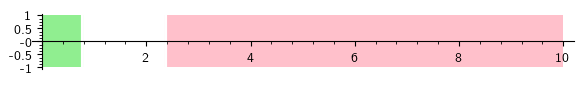

In [15]:
sigP.plot(aspect_ratio=p_ratio)

In [16]:
Q = Atomic(x - 1.1)
sigQ = Q.signal_for_system(*sys_args, **sys_kwargs)

run = True
vars = ['x', 'y']
var = x type(var) = <class 'str'> var_str = x
var = y type(var) = <class 'str'> var_str = y
Computed 501 flowpipes in 2.013033151626587 sec
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders

In [17]:
sigQ

Signal([0.0000000000000000 .. 10.000000000000000], [([0.64000000000000056 .. 3.2064719457580462], True), ([3.8200000000000033 .. 10.000000000000000], False)], mask=None)

E.g. atomic proposition $\displaystyle \psi \triangleq x > 1.1$ has signal $s_{\psi}:\mathbb R_{\geq 0} \to \{\mathbf F, \mathbf U, \mathbf T\}$ defined by
$$s_{\psi} = (([0.641, 3.206], \mathbf T), ([3.821, 5], \mathbf F))$$

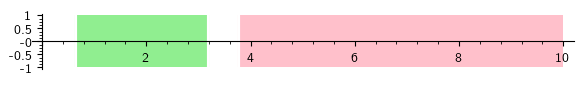

In [18]:
sigQ.plot(aspect_ratio=p_ratio)

In general we can find signals for atomic propositions by combining Flow* with the Extending Interval Newton method (based on method proposed for Ishii et al.).

We can then compose these to give signals for complex propositions e.g.

In [19]:
p_ratio

1/2

In [20]:
res = graphics_array(
    [
        sigP.plot(aspect_ratio=p_ratio) + text(r'$\varphi$', (10.8, 1), fontsize="xx-large"),
        sigQ.plot(aspect_ratio=p_ratio) + text(r"$\psi$", (10.8, 1), fontsize="xx-large"),
        (sigP & sigQ).to_domain(RIF(0, 10)).plot(aspect_ratio=p_ratio)
            + text(r"$\varphi \wedge \psi$", (10.8, 1), fontsize="xx-large"),
        (sigP | sigQ).to_domain(RIF(0, 10)).plot(aspect_ratio=p_ratio)
            + text(r"$\varphi \vee \psi$", (10.8, 1), fontsize="xx-large"),
    ],
    4, 1
)

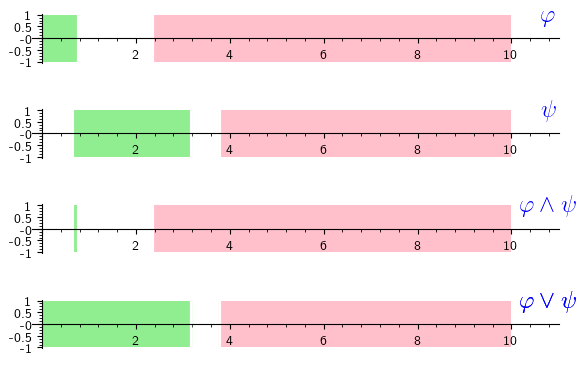

In [21]:
res

Or time shift signals for temporal operators:

In [22]:
res = graphics_array(
    [
         sigP.plot(aspect_ratio=p_ratio)
            + text('$\\varphi$', (10.8, 1), fontsize="xx-large"),
         sigP.G(RIF(2, 5)).plot(aspect_ratio=p_ratio)
            + text('$\\mathop{\\mathbf G_{[2, 5]}}\\varphi$', (10.8, 1), fontsize="xx-large"),
         sigP.F(RIF(2, 5)).plot(aspect_ratio=p_ratio)
            + text('$\\mathop{\\mathbf F_{[2, 5]}}\\varphi$', (10.8, 1), fontsize="xx-large")
    ],
    3, 1
)

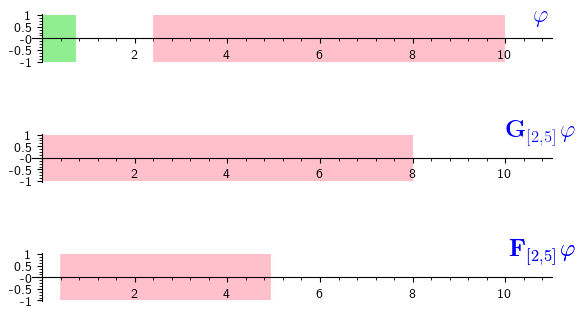

In [23]:
with suppress_warnings():
    res.show()

The until operator $\varphi \mathop{\mathbf U_{[a, b]}} \psi$ is more tricky.

The two-valued case used a decomposition into boolean signals

$$
    s_{\varphi \mathop{\mathbf U_{[a, b]}} \psi}
    =
    \bigvee_j s_\varphi^j \mathop{\mathbf{U}_{[a, b]}}s_{\psi} 
    =
    \bigvee_j s_\varphi^j \mathop{\mathbf{F}_{[a, b]}} \left(s_\varphi^j \wedge s_{\psi}\right) 
$$

and $s_\varphi = \bigvee_j s_\varphi^j$ where $s_j$ is a *unitary signal* e.g.

$s_\varphi = s_{\varphi}^1 \vee s_{\varphi}^2$ where we have signals

In [24]:
sig  = Signal(RIF(0, 10),
              [(RIF(0, 2), False), (RIF(2, 3), True), (RIF(3, 4), False), (RIF(4, 6), True), (RIF(6, 10), False)])
sig1 = Signal(RIF(0, 10),
              [(RIF(0, 2), False), (RIF(2, 3), True), (RIF(3, 10), False)])
sig2 = Signal(RIF(0, 10),
              [(RIF(0, 4), False), (RIF(4, 6), True), (RIF(6, 10), False)])

res = graphics_array([sig.plot(aspect_ratio=p_ratio)  + text(r"$s_\varphi$",   (10.8, 1), fontsize="xx-large"),
                      sig1.plot(aspect_ratio=p_ratio) + text(r"$s_\varphi^1$", (10.8, 1), fontsize="xx-large"),
                      sig2.plot(aspect_ratio=p_ratio) + text(r"$s_\varphi^2$", (10.8, 1), fontsize="xx-large")],
                     3, 1)

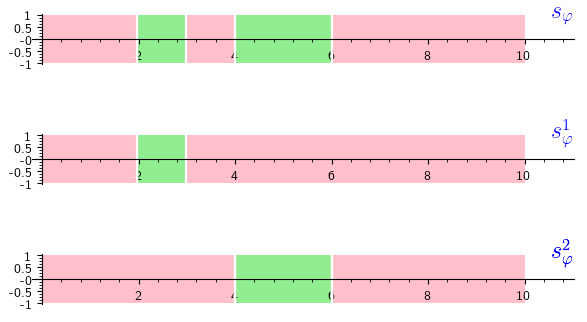

In [25]:
res

For three-valued signals we extend this into a decomposition into three-valued step-signals e.g. $s_\varphi = \bigvee_j s_\varphi^j$ 

In [54]:
sig  = Signal(RIF(0, 10),
              [(RIF(0, 1), False), (RIF(2, 3), True), (RIF(4, 5), True), (RIF(6, 7), False), (RIF(8, 9), True)])
sig1 = Signal(RIF(0, 10),
              [(RIF(0, 1), False), (RIF(2, 3), True), (RIF(6, 10), False)])
sig2 = Signal(RIF(0, 10),
              [(RIF(0, 1), False), (RIF(4, 5), True), (RIF(6, 10), False)])
sig3 = Signal(RIF(0, 10),
              [(RIF(0, 7), False), (RIF(8, 9), True)])

res = graphics_array([sig.plot(aspect_ratio=p_ratio)  + text(r"$s_\varphi$",   (10.8, 1), fontsize="xx-large"),
                      sig1.plot(aspect_ratio=p_ratio) + text(r"$s_\varphi^1$", (10.8, 1), fontsize="xx-large"),
                      sig2.plot(aspect_ratio=p_ratio) + text(r"$s_\varphi^2$", (10.8, 1), fontsize="xx-large"),
                      sig3.plot(aspect_ratio=p_ratio) + text(r"$s_\varphi^3$", (10.8, 1), fontsize="xx-large")],
                     4, 1)

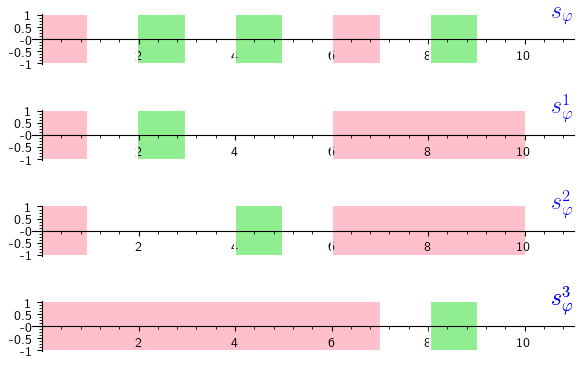

In [55]:
res

We can then compute $ 
s_{\varphi \mathop{\mathbf U_{[a, b]}} \psi}
=
\bigvee_j s_\varphi^j \wedge \mathop{\mathbf{F}_{[a, b]}} \left(s_\varphi^j \wedge s_{\psi}\right)$ e.g.

In [136]:
label_pos = (10.8, 1)
res = graphics_array(
    [sig.plot(aspect_ratio=p_ratio)  + text(r"$s_\varphi$",   label_pos, fontsize="xx-large"),
     sigQ.plot(aspect_ratio=p_ratio)  + text(r"$s_\psi$",     label_pos, fontsize="xx-large"),
     (sig1 & sigQ).plot(aspect_ratio=p_ratio) + text(r"$s_\varphi^1$", label_pos, fontsize="xx-large"),
     (sig2 & sigQ).plot(aspect_ratio=p_ratio) + text(r"$s_\varphi^2$", label_pos, fontsize="xx-large"),
     (sig3 & sigQ).plot(aspect_ratio=p_ratio) + text(r"$s_\varphi^3$", label_pos, fontsize="xx-large")],
     5, 1)

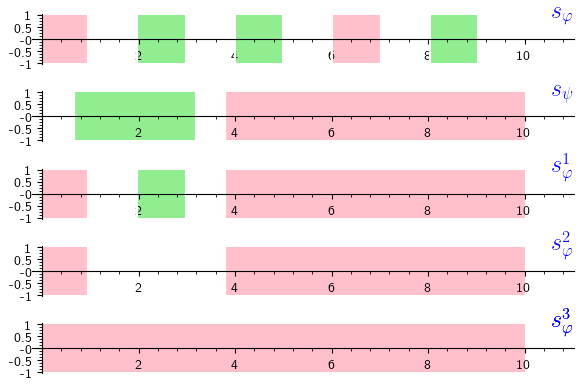

In [137]:
with suppress_warnings():
    res.show()

In [ ]:
label_pos = (8.3, 0)
text_kwargs = dict(fontsize="xx-large", horizontal_alignment="left", axes=False, background_color="white",
                   zorder=11)
# rect = polygon([(9.8, -1), (9.8, 1), (16, 1), (16, -1)],
#                color="white", zorder=10)
terms = [(s & sigQ).F(RIF(0.5, 2)) for s in [sig1, sig2, sig3]]
figs = [
    terms[0].plot(aspect_ratio=p_ratio)
         + text(r"$\mathop{\mathbf F_{[0.5, 2]}} \left(s_\varphi^1 \wedge \psi\right)$",
                label_pos, **text_kwargs),
     terms[1].plot(aspect_ratio=p_ratio)
         + text(r"$\mathop{\mathbf F_{[0.5, 2]}} \left(s_\varphi^2 \wedge \psi\right)$",
                label_pos, **text_kwargs),
     terms[2].plot(aspect_ratio=p_ratio)
         + text(r"$\mathop{\mathbf F_{[0.5, 2]}} \left(s_\varphi^3 \wedge \psi\right)$",
                label_pos, **text_kwargs),
]
res = graphics_array(figs, 3, 1)

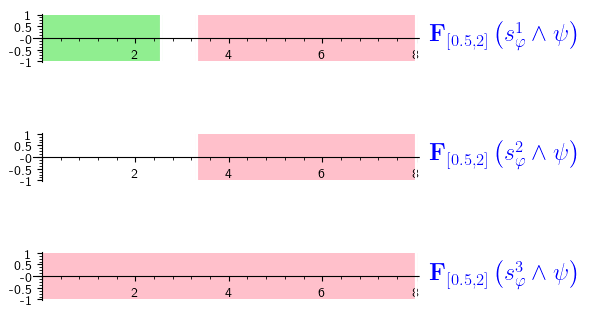

In [135]:
with suppress_warnings():
    res.show()

In [ ]:
label_pos = (10, 0)
text_kwargs = dict(fontsize="xx-large", horizontal_alignment="left", axes=False, background_color="white",
                   zorder=11)
rect = polygon([(9.8, -1), (9.8, 1), (16, 1), (16, -1)],
               color="white", zorder=10)
terms = [s & (s & sigQ).F(RIF(0.5, 2)) for s in [sig1, sig2, sig3]]
figs = [
    terms[0].plot(aspect_ratio=p_ratio)
         + text(r"$s_\varphi^1 \wedge \mathop{\mathbf F_{[0.5, 2]}} \left(s_\varphi^1 \wedge \psi\right)$",
                label_pos, **text_kwargs)
         + rect,
     terms[1].plot(aspect_ratio=p_ratio)
         + text(r"$s_\varphi^2 \wedge \mathop{\mathbf F_{[0.5, 2]}} \left(s_\varphi^2 \wedge \psi\right)$",
                label_pos, **text_kwargs)
         + rect,
     terms[2].plot(aspect_ratio=p_ratio)
         + text(r"$s_\varphi^3 \wedge \mathop{\mathbf F_{[0.5, 2]}} \left(s_\varphi^3 \wedge \psi\right)$",
                label_pos, **text_kwargs)
         + rect,
     (terms[0] | terms[1] | terms[2]).plot(aspect_ratio=p_ratio)
         + text(r"$s_{\varphi \mathop{\mathbf U_{[0.5, 2]}} \psi}$",
                label_pos, **text_kwargs)
         + rect
]
res = graphics_array(figs, 4, 1)

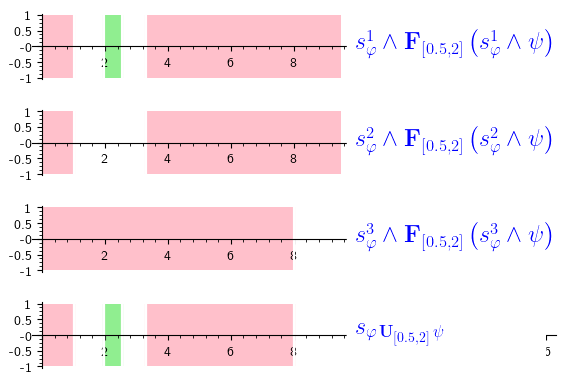

In [130]:
with suppress_warnings():
    res.show()

For context operator $\mathcal C \triangleright \varphi$

## Monitoring under masks

A major limitation of signals is that they must be calculated for an unbroken interval of time.

e.g. if we want to know if $\mathop{\mathbf F_{[9, 10]}} \varphi$ is true at time zero, the signal for $\varphi$ must be computed for $10$ seconds even though it only refers to the behaviour of the system for the last one second.

Masking restricts signal monitoring to a specific subregion of time describe by a boolean signal.

e.g. for atomic proposition $\varphi \triangleq (x - 1)^2 + y^2 > 0.2$

In [28]:
mask = Mask(RIF(0, 10),
            [RIF(0.5, 4), RIF(7, 8)])
res = graphics_array(
    [
        sigP.plot(aspect_ratio=p_ratio)
            + text(r'$\varphi$', (10.8, 1), fontsize="xx-large"),
        mask.plot(aspect_ratio=p_ratio)
            + text(r'$m$', (10.8, 1), fontsize="xx-large"),
        P.signal_for_system(*sys_args, mask=mask, **sys_kwargs).plot(aspect_ratio=p_ratio)
            + text(r'$\varphi|_m$', (10.8, 1), fontsize="xx-large"),
    ],
    3, 1
)

run = True
vars = ['x', 'y']
var = x type(var) = <class 'str'> var_str = x
var = y type(var) = <class 'str'> var_str = y
Computed 501 flowpipes in 1.5980370044708252 sec
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
order

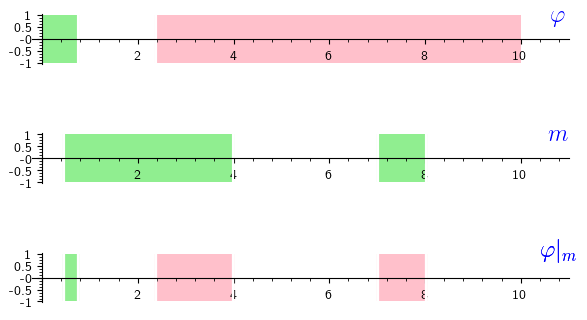

In [29]:
with suppress_warnings():
    res.show()

<p class="list-heading"><strong>Method:</strong></p>

 - Monitor only Taylor-model segments which intersect with the mask
 - On these, restrict the Taylor-model time-domain

### Basic temporal operators

For temporal operators we timeshift forwards instead of backwards

Suppose we want to monitor $\mathop{\mathbf F_{[a, b]} \varphi}$ under mask $m = (I_j)_j$. We can do this knowing $s_{\varphi}(t)$ at any timepoint $t$ such that $m(t')$ is true at some point between $a$ and $b$ seconds ago. Therefore it suffices to monitor $\varphi$ under the mask,
$$
    \mathop{{\mathbf P}_{[a, b]}} m = (I_j \oplus [a, b])_j
$$

In fact, the same mask works for $\mathop{\mathbf G_{[a, b]} \varphi}$ also.

In [30]:
label_pos = (14.8, 1)
duration = 15.5
p_range = RIF(0, duration)
sigPl = P.signal_for_system(*(sys_args[:-1] + (14,)), **sys_kwargs)
res = graphics_array(
    [
        sigPl.to_domain(p_range).plot(aspect_ratio=p_ratio)
            + text(r'$\varphi$', label_pos, fontsize="xx-large"),
        mask.to_domain(p_range).plot(aspect_ratio=p_ratio)
            + text(r'$m$', label_pos, fontsize="xx-large"),
        mask.P(RIF(2, 5)).to_domain(p_range).plot(aspect_ratio=p_ratio)
            + text(r'$\mathop{\mathbf P_{[2, 5]}} m$', label_pos, fontsize="xx-large"),
        P.signal_for_system(*(sys_args[:-1] + (duration,)),
                            mask=mask.P(RIF(2, 5)),
                            **sys_kwargs).to_domain(p_range).plot(aspect_ratio=p_ratio)
            + text(r'$\varphi|_{\mathop{\mathbf P_{[2, 5]}} m}$', label_pos, fontsize="xx-large"),
#         P.signal_for_system(*(sys_args[:-1] + (duration,)),
#                             mask=mask.P(RIF(2, 5)),
#                             **sys_kwargs).F(RIF(2, 5)).to_domain(p_range).plot(aspect_ratio=p_ratio)
#             + text(r'$\mathop{\mathbf F_{[2, 5]}} \varphi|_m$', label_pos, fontsize="xx-large"),
        F(RIF(2, 5), P
          ).signal_for_system(*sys_args, mask=mask,
                              **sys_kwargs).with_mask(mask).to_domain(p_range).plot(aspect_ratio=p_ratio)
            + text(r'$\mathop{\mathbf F_{[2, 5]}} \varphi|_m$', label_pos, fontsize="xx-large"),
    ],
    5, 1
)

run = True
vars = ['x', 'y']
var = x type(var) = <class 'str'> var_str = x
var = y type(var) = <class 'str'> var_str = y
Computed 701 flowpipes in 2.297847032546997 sec
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders

composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
o

E.g.

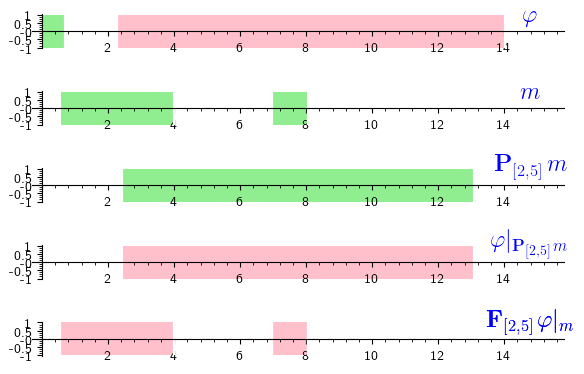

In [31]:
with suppress_warnings():
    res.show()

### Logical operations

In propositional logic $\varphi \vee \psi$ shortcurcuiting allows us to avoid evaulating $\psi$ whenever $\varphi$ is true.

We extend this optimization to temporal logic by defining the *or-mask* of $\varphi$ by

$$
    m_\varphi^{\mathrm{or}}(t) = \begin{cases}
        \mathbf T & \text{if $s_\varphi(t) = \mathbf F$ or $s_\varphi(t) = \mathbf U$} \\
        \mathbf F & \text{if $s_\varphi(t) = \mathbf T$}
    \end{cases}
$$

Then we can compute the signal for $\varphi \vee \psi$ under mask $m$ by
$$
    s_{\varphi \vee \psi}|_m
    =
    s_\varphi|_m \vee s_\psi|_{m \wedge m^{\mathrm{or}}_\varphi}
$$

In [47]:
label_pos = (11.2, 1)
res = graphics_array(
    [
        sigP.plot(aspect_ratio=p_ratio) + text(r'$\varphi$', label_pos, fontsize="xx-large"),
        sigQ.plot(aspect_ratio=p_ratio) + text(r"$\psi$", label_pos, fontsize="xx-large"),
        sigP.to_mask_or().plot(aspect_ratio=p_ratio) + text(r'$m_\varphi^{\mathrm{or}}$', label_pos, fontsize="xx-large"),
        (sigP | sigQ.with_mask(sigP.to_mask_or())).to_domain(RIF(0, 10)).plot(aspect_ratio=p_ratio)
            + text(r"$\varphi \vee \psi|_{m_\varphi^{\mathrm{or}}}$", label_pos, fontsize="xx-large"),
    ],
    4, 1
)

E.g. computing $\varphi \wedge \psi$

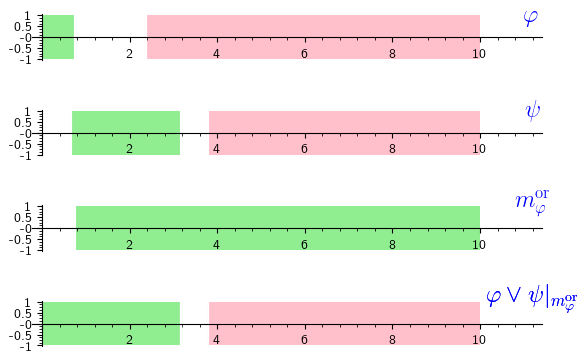

In [50]:
with suppress_warnings():
    res.show()

The case for $\varphi \vee \psi$ is dual.

**Audience question**: what mask should we use to monitor $\neg\varphi$ under $m$?

### Masking Until

How do we monitor $\varphi \mathop{\mathbf U_{[a, b]}} \psi$ under mask $m$? 

**One approach**: use the equation,

$$
    s_{\varphi \mathop{\mathbf U_{[a, b]}} \psi}
    =
    \bigvee_j s_\varphi^j \wedge \mathop{\mathbf{F}_{[a, b]}} \left(s_\varphi^j \wedge s_{\psi}\right) 
$$

and apply masking methods for both logical and temporal operators to find a suitable mask for $\psi$.

**A simpler way**: in fact, it surfices to monitor $\psi$ under the mask

$$
   \mathop{\mathbf H_{[0, b]}} \left(m \wedge m_{\varphi}^{\mathrm{or}}\right)
$$

$\mathbf{H}_{[0, a]} \zeta$: the proposition $\zeta$ has *historically* held between $0$ and $a$ seconds ago. 